In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
from processing import tf_image
import cv2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
isess = tf.InteractiveSession()

In [413]:
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]
anchor_sizes=[(21., 45.),
              (45., 99.),
              (99., 153.),
              (153., 207.),
              (207., 261.),
              (261., 315.)]
scale_range=[0.15, 0.9]
scale_range_max = [0.2, 1.1]
scales = [scale_range[0] + i*(scale_range[1] - scale_range[0])/5  for i in range(6)]
scales_max = [scale_range_max[0] + i*(scale_range_max[1] - scale_range_max[0])/5  for i in range(6)]
anchor_sizes = [(300*scales[i], 300*scales_max[i]) for i in range(6)]
anchor_sizes
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]

text_shape (300, 300)
0.5
file_path: ../data/ICDAR2013/*.tfrecord


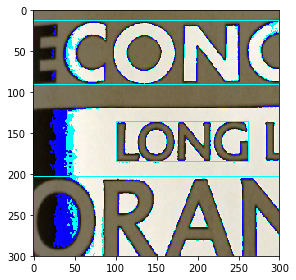

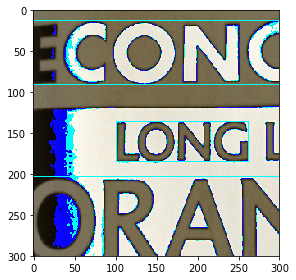

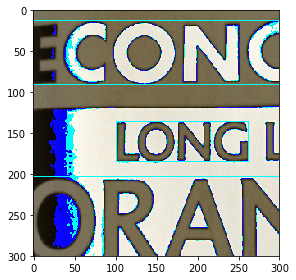

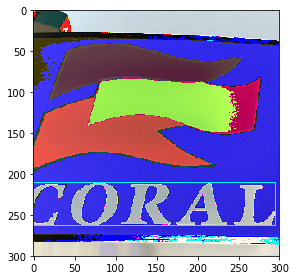

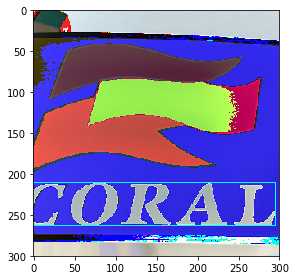

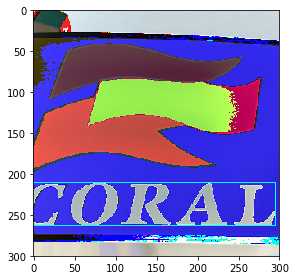

0
55


In [45]:
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    
    #image = (dst_image - tf.reduce_min(dst_image))/ (tf.reduce_max(dst_image) - tf.reduce_min(dst_image))
    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            error = []
            box = []
            for i in xrange(2):
                rpredictions, rlocalisations, img ,gbboxes_= sess.run([gscores, glocalisations,dst_image,gbboxes])
                rpredictions_2 = list(rpredictions)
                localb = []
                for i in range(6):
                    decodeb = np_methods.ssd_bboxes_decode(rlocalisations[i],text_anchors[i])
                    localb.append(decodeb[np.where(rpredictions[i] > 0.5)])
                    pre2 = np.expand_dims(1-rpredictions[i], -1)
                    rpredictions[i] = np.concatenate([pre2, np.expand_dims(rpredictions[i], -1)],axis = -1)
                rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
                        rpredictions, rlocalisations, text_anchors,
                        select_threshold=0.001, img_shape=text_shape, num_classes=2, decode=True)

                rbboxes = np_methods.bboxes_clip(rbboxes)
                rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=-1)
                rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, 
                                                                  nms_threshold=0.45)
                #Resize bboxes to original image shape. Note: useless for Resize.WARP!
                bboxes = np.concatenate(localb, 0)
                           
                image_ = np.uint8(img) *255
                img_ = image_.copy()
                visualize_bbox(img_, rbboxes)
                
                img = image_.copy()
                visualize_bbox(img, bboxes)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                
                img = image_.copy()

                
                for i in range(6):
                    #pass
                    box.append(rlocalisations[i][np.where(rpredictions_2[i] > 0.5)].shape[0])
                #error.append((gbboxes_.shape[0] - rbboxes.shape[0]))
                error.append((gbboxes_.shape[0] - rbboxes.shape[0]))
            print sum(error)
            print sum(box)

In [44]:
print text_anchors[0][2]
print text_anchors[0][3]
print text_anchors[0][1][-1,-1,:,:]

[ 0.07        0.04949747  0.04041452  0.03130495  0.02645751  0.02213594]
[ 0.07        0.09899495  0.12124356  0.15652476  0.1852026   0.22135943]
[[ 0.9868421]
 [ 0.9868421]]


In [349]:
print rbboxes.shape
print gbboxes_.shape
#
np_methods.bboxes_clip(gbboxes_)
rbboxes.shape

(6, 4)
(6, 4)


(6, 4)

In [25]:
rlocalisations[2][np.where(rpredictions_2[2] > 0.5)]

array([[ 3.51170921,  0.86333787,  2.25124788, -0.83508193],
       [ 2.72015834,  1.11456442,  0.97418404,  0.44198248],
       [ 2.29895329,  1.31877029,  0.13300337,  1.28316283],
       [ 1.76216304,  0.86333787,  2.25124788, -0.83508193],
       [ 1.36496568,  1.11456442,  0.97418404,  0.44198248],
       [ 1.15360653,  1.31877029,  0.13300337,  1.28316283],
       [ 0.96517646,  1.57623196, -0.75868422,  2.17484999],
       [ 0.01261697,  0.86333787,  2.25124788, -0.83508193],
       [ 0.00977306,  1.11456442,  0.97418404,  0.44198248],
       [ 0.00825974,  1.31877029,  0.13300337,  1.28316283],
       [ 0.0069106 ,  1.57623196, -0.75868422,  2.17484999],
       [-1.73692966,  0.86333787,  2.25124788, -0.83508193],
       [-1.34542   ,  1.11456442,  0.97418404,  0.44198248],
       [-1.13708735,  1.31877029,  0.13300337,  1.28316283],
       [-0.95135552,  1.57623196, -0.75868422,  2.17484999],
       [-3.48647523,  0.86333787,  2.25124788, -0.83508193],
       [-2.70061231,  1.

In [20]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions_2[i] > 0.5)].shape

(0, 4)
(0, 4)
(36, 4)
(4, 4)
(0, 4)
(0, 4)


In [29]:
isess.run(text_anchors)

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [10]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    #print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

In [281]:
import math
min_dim = 300
min_ratio = 20
max_ratio = 95
step = int(math.floor((max_ratio - min_ratio) / (6 - 2)))
min_sizes = []
max_sizes = []
for ratio in xrange(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 10 / 100.] + min_sizes
max_sizes = [[]] + max_sizes

In [272]:
np.savetxt(fname='result.csv',X=a,delimiter=',',fmt='%.4f')

In [282]:
max_sizes

[[], 114.0, 168.0, 222.0, 276.0, 330.0]

In [283]:
anchor_sizes

[30.0, 60.0, 114.0, 168.0, 222.0, 276.0]